In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Some libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

2.12.0


## Load the data.

In [ ]:
input_file = np.load('/kaggle/input/plants/public_data.npz', allow_pickle=True)
data = input_file['data']

labels = input_file['labels']

label_dict = {'healthy': 0, 'unhealthy': 1}
labels = np.array([label_dict[label] for label in labels])

## Preprocess with convnext preprocess function.

In [2]:
#data = data/255.0

from keras.applications.convnext import preprocess_input
data = preprocess_input(data)

## Remove outliers.

In [3]:
shrek_indices = []
trol_indices = []
new_data = []
new_labels = []
for i, image in enumerate(data):
  if np.sum(data[506] - image) == 0:
    shrek_indices.append(i)
  elif np.sum(data[338] - image) == 0:
    trol_indices.append(i)
  else:
    new_data.append(image)
    new_labels.append(labels[i])

images = np.array(new_data)
labels = np.array(new_labels)
#labels = tfk.utils.to_categorical(labels)

## Split the dataset into train, validation and test.

In [25]:
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=seed)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2,random_state=seed)

In [6]:
input_shape = X_train.shape[1:]  # Input shape for the model

## Load the base model: ConvNeXtLarge

In [8]:
learned_model = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights=None,
    pooling='max',
)

learned_model.load_weights('/kaggle/input/convxnet/convnext_large_notop.h5')

## Freeze all layers.

In [9]:
learned_model.trainable = False

## Data augmentation.

In [10]:
preprocessing = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.9),
    tfkl.GaussianNoise(0.3),
    tfkl.RandomContrast(0.4),
    tfkl.RandomBrightness(0.4),
], name='preprocessing')


input_layer = tfkl.Input(shape=input_shape)
x = preprocessing(input_layer)

In [11]:
x = learned_model(x)

## Add custom layers.

In [12]:
from keras import regularizers

x = tfkl.Flatten(name='flattenLast')(x)
x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(512, activation='relu', name='Dense_1', kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(256, activation='relu', name='Dense_2', kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(128, activation='relu', name='Dense_3', kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(64, activation='relu', name='Dense_4', kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(16, activation='relu', name='Dense_5', kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = tfkl.Dropout(0.2)(x)
output_layer = tfkl.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics="accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional)  (None, 1536)             196230336 
                                                                 
 flattenLast (Flatten)       (None, 1536)              0         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 Dense_1 (Dense)             (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

## Set the callbacks.

In [104]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [105]:
model_checkpoint = tfk.callbacks.ModelCheckpoint('best_model_finetune.h5', monitor='val_accuracy', save_best_only=True, mode='max')

## Compute class weights.

In [14]:
from sklearn.utils.class_weight import compute_class_weight
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {0: 0.81, 1: 1.29} #precomputed

print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.81, 1: 1.29}


## Set the scheduler for learning rate.

In [15]:
def scheduler(epoch, lr):
  if epoch < 15:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Fit the model.

In [ ]:
batch_size=32
epochs=20
tl_history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[lrscheduler], #earlystopping, model_checkpoint
    verbose=1
)

## Plot loss and accuracy.

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history.history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_loss'], alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history.history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_accuracy'], alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [78]:
# Predict the test set with the CNN
predictions = model.predict(X_test)
print(predictions.shape)

32/32 [==============================] - 7s 213ms/step

(1001, 1)


In [82]:
new = []
for p in predictions:
  if p[0] > 0.5:
    new.append(1)
  else:
    new.append(0)

In [84]:
predictions = new

## Compute confusion matrix.

Accuracy: 0.5814

Precision: 0.5322

Recall: 0.5265

F1: 0.5208


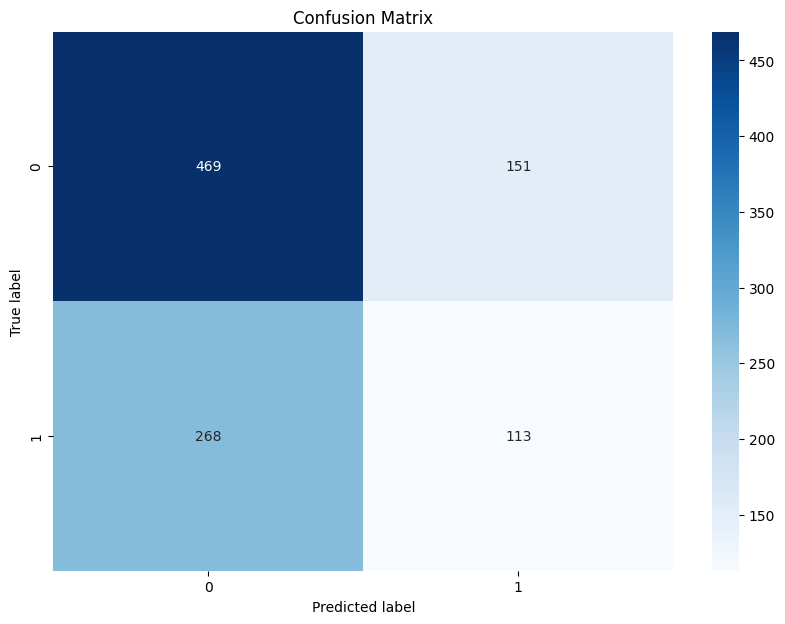

In [89]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Compute the classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test,predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [90]:
# Save the best model
model.save('ConvNetTransferlearning')
del model

## Start fine-tuning.

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('ConvNetTransferlearning')
ft_model.summary()

## Unfreeze some layers.

In [16]:
# Set all layers to True
ft_model.get_layer('convnext_large').trainable = True
#for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
#   print(i, layer.name, layer.trainable)

In [17]:
# Freeze first N layers, e.g., until 84th
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:84]):
  layer.trainable=False

In [18]:
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
batch_size=16
epochs=20
class_weights_dict = {0: 0.81, 1: 1.29} #precomputed
ft_history = ft_model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[lrscheduler],
    verbose=1
)

Epoch 1/20
283/283 [==============================] - 143s 251ms/step - loss: 301.0202 - accuracy: 0.5152 - val_loss: 287.9361 - val_accuracy: 0.6555 - lr: 1.0000e-05
Epoch 2/20
283/283 [==============================] - 52s 184ms/step - loss: 275.4790 - accuracy: 0.6115 - val_loss: 262.9157 - val_accuracy: 0.7437 - lr: 1.0000e-05
Epoch 3/20
283/283 [==============================] - 52s 184ms/step - loss: 251.0309 - accuracy: 0.7123 - val_loss: 239.0104 - val_accuracy: 0.8193 - lr: 1.0000e-05
Epoch 4/20
283/283 [==============================] - 52s 184ms/step - loss: 227.7341 - accuracy: 0.7823 - val_loss: 216.2506 - val_accuracy: 0.8908 - lr: 1.0000e-05
Epoch 5/20
283/283 [==============================] - 52s 184ms/step - loss: 205.5942 - accuracy: 0.8427 - val_loss: 194.7222 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 6/20
283/283 [==============================] - 52s 184ms/step - loss: 184.6847 - accuracy: 0.8600 - val_loss: 174.4479 - val_accuracy: 0.9286 - lr: 1.0000e-05
Epo

## Plot loss and accuracy after tuning.

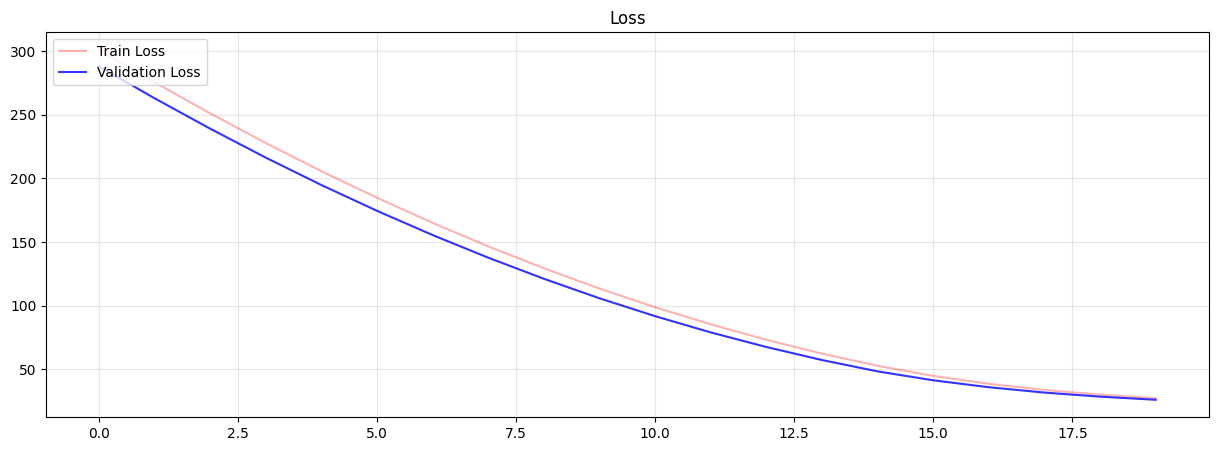

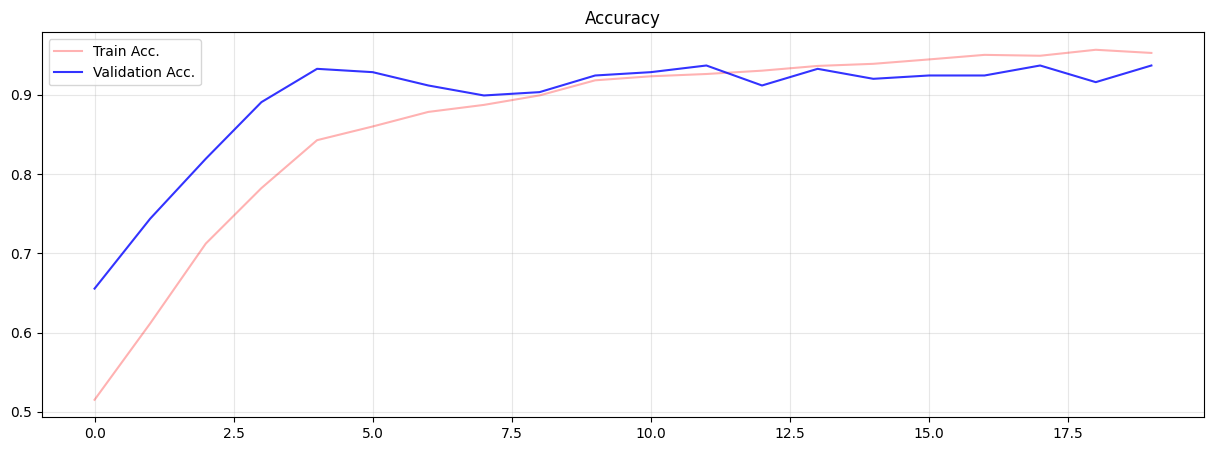

In [21]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(ft_history.history['loss'], alpha=.3, label='Train Loss',color='red')
plt.plot(ft_history.history['val_loss'], label='Validation Loss', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history.history['accuracy'], label='Train Acc.', alpha=.3, color='red')
plt.plot(ft_history.history['val_accuracy'], label='Validation Acc.', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [27]:
predictions = model.predict(X_test)

# Converting probabilities to class labels
y_pred = (predictions > 0.5).astype('int32').flatten()

32/32 [==============================] - 8s 246ms/step


## Plot confusion matrix after tuning.

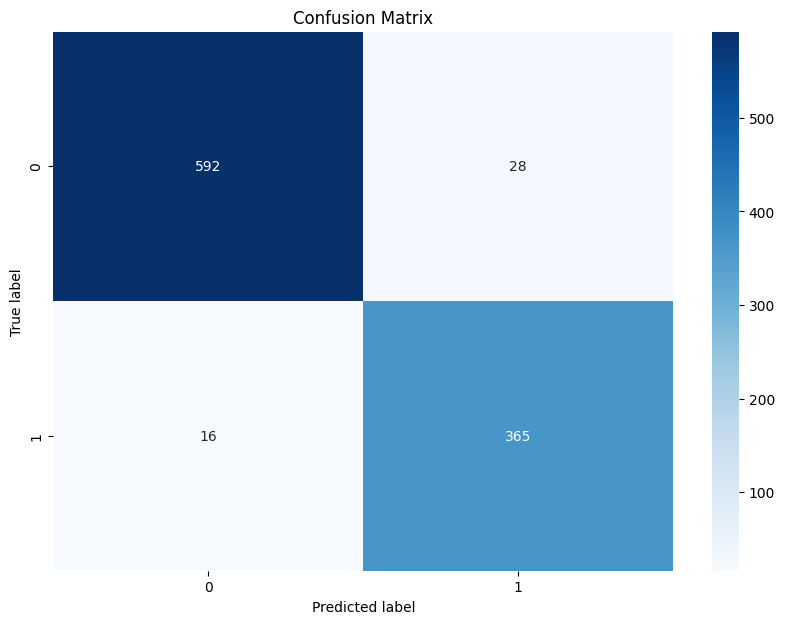

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Plot the histogram of the predicted probabilities.

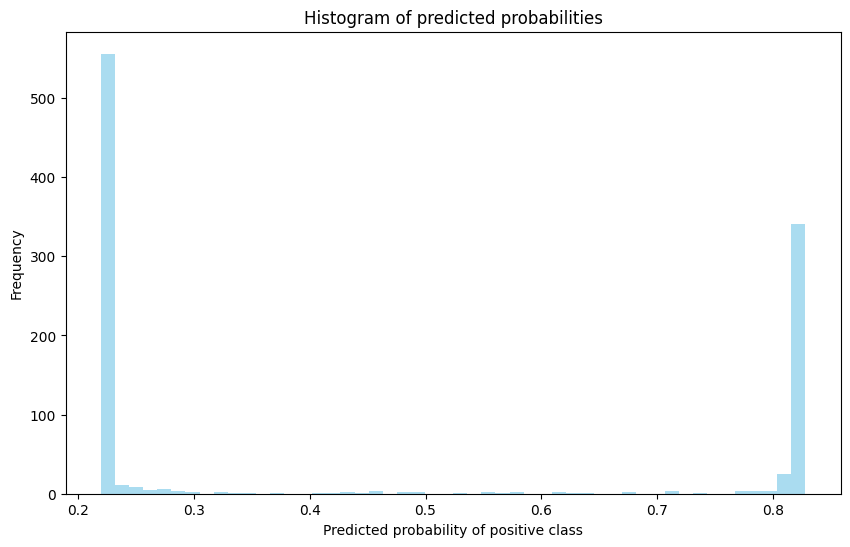

In [31]:
# Plot a histogram of the predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=50, color='skyblue', alpha=0.7)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of positive class')
plt.ylabel('Frequency')
plt.show()

## Save the model.

In [19]:
ft_model.save('/kaggle/working/final_submission')

In [20]:
!zip -r final.zip /kaggle/working/final_submission

  adding: kaggle/working/final_submission/ (stored 0%)
  adding: kaggle/working/final_submission/saved_model.pb (deflated 93%)
  adding: kaggle/working/final_submission/variables/ (stored 0%)
  adding: kaggle/working/final_submission/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/final_submission/variables/variables.index (deflated 78%)
  adding: kaggle/working/final_submission/assets/ (stored 0%)
  adding: kaggle/working/final_submission/fingerprint.pb (stored 0%)
  adding: kaggle/working/final_submission/keras_metadata.pb (deflated 96%)
